In [25]:
%reset 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import re

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


torch.Size([4, 3])


Text(0.5, 0, 'dim3')

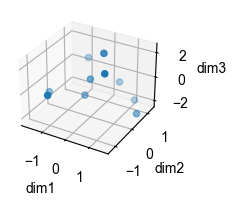

In [26]:
### tmp example 

# Create an embedding layer
embed = nn.Embedding(10, 3)  # 10 words, 3-dimensional embeddings

# Input tensor (batch of word indices)
input = torch.LongTensor([1, 4, 3, 2])

# Get embeddings
embeddings = embed(input)

print(embeddings.shape)  


import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


embeddings = embed(torch.LongTensor(np.linspace(0,9,10))).detach().numpy()

# Create a 3D surface plot using Matplotlib
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2])

# Customize the plot using Seaborn's styling options
sns.set_style("whitegrid")
ax.set_xlabel('dim1')
ax.set_ylabel('dim2')
ax.set_zlabel('dim3')

# Sample run with custom corpus


In [96]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

corpus = [
    "the quick brown fox jumps over the lazy dog",
    "the five boxing wizards jump quickly",
    "we saw five brown slugs last night",
    "some wizards worked their magic quickly",
    "magic faded from their memory soon after",
    "their brown hands withered and soon it was all over",
    "magic went over their hands",
    "it worked as long as memory held fast",
    "the wizards bled for their magic",
    "a quick jump was all they needed",
    "the withered hands became dust",
    "brown dust coated the land",
    "the brown fox sniffed the air and it was clear"
    # Add more sentences to your corpus
]

words = [word for sentence in corpus for word in preprocess_text(sentence)]

vocab = Counter(words)
vocab = {word: i for i, (word, count) in enumerate(vocab.items()) if count > 1} 
vocab = {word: i for i, (word, count) in enumerate(vocab.items())}

vocab_size = len(vocab)

In [97]:
vocab

{'the': 0,
 'quick': 1,
 'brown': 2,
 'fox': 3,
 'over': 4,
 'five': 5,
 'wizards': 6,
 'jump': 7,
 'quickly': 8,
 'worked': 9,
 'their': 10,
 'magic': 11,
 'memory': 12,
 'soon': 13,
 'hands': 14,
 'withered': 15,
 'and': 16,
 'it': 17,
 'was': 18,
 'all': 19,
 'as': 20,
 'dust': 21}

In [98]:
# Pam mod from Claude

## ------------------------------------------------------------------
## DATASET PROPERTIES
## ------------------------------------------------------------------

# set up custom dataloader, with preprocessing tools
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

class SkipGramDataset(Dataset):
    def __init__(self, corpus, vocab, window_size=2):
        self.data = []
        for sentence in corpus:
            words = preprocess_text(sentence)
            for i, word in enumerate(words):
                if word in vocab:
                    for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
                        if i != j and words[j] in vocab:
                            self.data.append((vocab[word], vocab[words[j]]))
                            
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

## ------------------------------------------------------------------
## MODEL PROPERTIES
## ------------------------------------------------------------------
    
# define mechanism to draw negative samples    
def get_negative_samples(batch_size, num_samples, vocab_size):
    return torch.randint(0, vocab_size, (batch_size, num_samples))

# define loss function and optimizer
def skip_gram_negative_sampling_loss(model, target, context, negative_samples):
    batch_size = target.shape[0]
    positive_loss = torch.mean(torch.log(torch.sigmoid(model(target, context))))
    negative_loss = torch.mean(torch.log(torch.sigmoid(-model(target.repeat(1, negative_samples.shape[1]), negative_samples.flatten()).view(batch_size, -1))))
    return -(positive_loss + negative_loss)

# define your model
class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramNegSampling, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, target, context):
        target_emb = self.embeddings(target)
        context_emb = self.output(context)
        return torch.sum(target_emb * context_emb, dim=1)

## ------------------------------------------------------------------
## TRAINING PROTOCOL
## ------------------------------------------------------------------

def train_skip_gram_model(model, dataset, num_epochs, batch_size, learning_rate, num_negative_samples):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)#, num_workers=2)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_target, batch_context in dataloader:
            negative_samples = get_negative_samples(batch_size, num_negative_samples, vocab_size)
            loss = skip_gram_negative_sampling_loss(model, batch_target, batch_context, negative_samples)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")


In [99]:
# Main execution
embedding_dim = 96 #this needs to be divisible by batch size
window_size = 2
num_epochs = 50
batch_size = 32
learning_rate = 0.01 #increase learning rate when have few train samples
num_negative_samples = 5

dataset = SkipGramDataset(corpus, vocab, window_size)
model = SkipGramNegSampling(vocab_size, embedding_dim)

train_skip_gram_model(model, dataset, num_epochs, batch_size, learning_rate, num_negative_samples)



Epoch 1/50, Loss: 10.4514
Epoch 2/50, Loss: 9.1797
Epoch 3/50, Loss: 9.6465
Epoch 4/50, Loss: 8.3264
Epoch 5/50, Loss: 6.8125
Epoch 6/50, Loss: 7.0380
Epoch 7/50, Loss: 6.0300
Epoch 8/50, Loss: 5.5029
Epoch 9/50, Loss: 4.8079
Epoch 10/50, Loss: 5.1078
Epoch 11/50, Loss: 5.1247
Epoch 12/50, Loss: 4.5924
Epoch 13/50, Loss: 4.0694
Epoch 14/50, Loss: 3.9053
Epoch 15/50, Loss: 3.6437
Epoch 16/50, Loss: 3.5778
Epoch 17/50, Loss: 3.1497
Epoch 18/50, Loss: 3.0467
Epoch 19/50, Loss: 3.0793
Epoch 20/50, Loss: 3.4831
Epoch 21/50, Loss: 2.7503
Epoch 22/50, Loss: 2.4994
Epoch 23/50, Loss: 2.4373
Epoch 24/50, Loss: 3.0650
Epoch 25/50, Loss: 2.0284
Epoch 26/50, Loss: 2.5681
Epoch 27/50, Loss: 2.5928
Epoch 28/50, Loss: 2.0030
Epoch 29/50, Loss: 2.1107
Epoch 30/50, Loss: 1.8256
Epoch 31/50, Loss: 2.0970
Epoch 32/50, Loss: 1.8928
Epoch 33/50, Loss: 2.2977
Epoch 34/50, Loss: 1.8362
Epoch 35/50, Loss: 1.6784
Epoch 36/50, Loss: 1.4149
Epoch 37/50, Loss: 1.7312
Epoch 38/50, Loss: 1.5896
Epoch 39/50, Loss: 1

In [162]:
wordlist = [k for k in iter(vocab.keys())]
# print(wordlist)

Embedding for 'dust': [[ 0.21945988  1.1764295  -1.4611852  -0.18026064 -0.78887796 -1.3359647
  -0.6546871  -0.17525178  0.54689336 -0.3250825   0.86959136  1.0185804
  -2.2881556   0.809982    0.89064217 -1.7091453  -0.63408506 -1.1094322
   0.44005778 -0.8271995  -0.919059    0.9608377  -0.24831927  1.4367152
  -1.5163509   0.8382067   0.5116631  -0.10990898  0.19604656  1.3597084
   0.45080042  1.2045135   0.83245677  0.53935844  0.34836322 -0.5979176
  -0.19959797  0.10125067  0.74846053  0.18983449 -1.5595146   1.4963167
   0.02911589  1.0145794  -0.5544937   0.07524031  1.0818726  -0.3212605
   0.5308675  -0.25109658 -1.2385468   0.06981643 -0.20879817 -0.44348228
  -0.6282715   0.5493253   0.37070385  0.81486595 -1.6604741   0.13270913
  -1.0134832   0.7633863   0.14795288  0.4836618  -0.44594747  0.26832637
  -0.98714143 -1.3772928   0.06191068 -0.17182899  0.9750807  -0.5246336
  -0.29885605  0.3305674   0.23849519  0.46252123 -0.38878432  0.85875285
   0.10566909 -0.09853905

Text(0.5, 0, 'dim3')

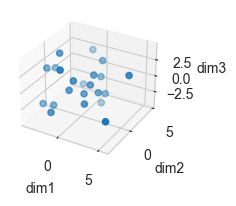

In [161]:
# Visualize the embeddings
def get_word_vector(word, model, vocab):
    return model.embeddings(torch.tensor([vocab[word]])).detach().numpy()

# Example: Get the embedding for a specific word
word = wordlist[-1]
vector = get_word_vector(word, model, vocab)
print(f"Embedding for '{word}': {vector}")

# To visualize the embeddings, you can use techniques like t-SNE or PCA

V = []
for word in wordlist:
    
    V.append(get_word_vector(word,model,vocab)[0])
    
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
V_pca = pca.fit_transform(V)


# Create a 3D surface plot using Matplotlib
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V_pca[:,0], V_pca[:,1], V_pca[:,2])

# Customize the plot using Seaborn's styling options
sns.set_style("whitegrid")
ax.set_xlabel('dim1')
ax.set_ylabel('dim2')
ax.set_zlabel('dim3')